<a href="https://colab.research.google.com/github/fatimasood/CNN-Based-Early-Autism-Detection-Using-Facial-Image-Analysis/blob/main/Xception_vs_VGG16_Autism_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Re-implementation of:
# "Autism Spectrum Disorder Detection Using Face Features based on Deep Neural Network"
# Ali F. Rashid et al., Wasit Journal of Computer and Mathematical Science (2023)
#
# Dataset: https://www.kaggle.com/datasets/arifulislamjoy/autism-image-dataset
# Models: Xception, VGG16 (Transfer Learning)
# Metrics: Accuracy, Sensitivity, Specificity, Confusion MatrixAutism Spectrum Disorder Detection using Facial Images

# Environment Setup

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, GlobalMaxPooling2D, Flatten, BatchNormalization, Dropout
)
from tensorflow.keras.applications import Xception, VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report


In [3]:

# Reproducibility (as close as DL allows)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [20]:

# Dataset

!pip install kaggle

import os

# create kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# move uploaded kaggle.json
!mv kaggle.json /root/.kaggle/

# permission fix (important)
!chmod 600 /root/.kaggle/kaggle.json

print("Kaggle API configured")



✅ Kaggle API configured


In [21]:
!kaggle datasets download -d arifulislamjoy/autism-image-dataset


Dataset URL: https://www.kaggle.com/datasets/arifulislamjoy/autism-image-dataset
License(s): unknown
  0% 0.00/115M [00:00<?, ?B/s]
100% 115M/115M [00:00<00:00, 1.34GB/s]


In [22]:
!unzip autism-image-dataset.zip

Archive:  autism-image-dataset.zip
  inflating: AutismDataset/test/Autistic/Autistic.0.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.1.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.10.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.100.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.101.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.102.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.103.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.104.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.105.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.106.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.107.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.108.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.109.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.11.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.110.jpg  
  inflating: AutismDataset/test/Autistic/Autistic.111.jpg  
  inflating

In [24]:
BASE_DIR = "/content/AutismDataset"

TRAIN_DIR = BASE_DIR + "/train"
VAL_DIR   = BASE_DIR + "/valid"
TEST_DIR  = BASE_DIR + "/test"


In [25]:
import os

for split in ["train", "valid", "test"]:
    for cls in ["Autistic", "Non_Autistic"]:
        path = f"{BASE_DIR}/{split}/{cls}"
        print(split, cls, ":", len(os.listdir(path)))


train Autistic : 1270
train Non_Autistic : 1270
valid Autistic : 50
valid Non_Autistic : 50
test Autistic : 150
test Non_Autistic : 150


In [26]:

# Data Preprocessing (Paper-aligned)


train_gen = ImageDataGenerator(rescale=1./255)
val_gen   = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_data.num_classes
CLASS_NAMES = list(train_data.class_indices.keys())


Found 2540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [27]:
print(train_data.class_indices)


{'Autistic': 0, 'Non_Autistic': 1}


In [28]:
# Metric Utilities (Sensitivity & Specificity)

def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return accuracy, sensitivity, specificity, cm


In [29]:

# Xception Model


def build_xception():
    base = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    for layer in base.layers:
        layer.trainable = False

    x = base.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=output)

    model.compile(
        optimizer=RMSprop(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [30]:


# VGG16 Model


def build_vgg16():
    base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    for layer in base.layers:
        layer.trainable = False

    x = base.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [31]:

# Training Utility


def train_model(model, name):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f"{name}.h5", monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    return history


In [32]:

# Train Models

xception_model = build_xception()
vgg16_model = build_vgg16()

print("Training Xception...")
hist_x = train_model(xception_model, "xception")

print("Training VGG16...")
hist_v = train_model(vgg16_model, "vgg16")


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training Xception...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6112 - loss: 0.8295

80/80 ━━━━━━━━━━━━━━━━━━━━ 619s 8s/step - accuracy: 0.6115 - loss: 0.8286 - val_accuracy: 0.6700 - val_loss: 0.6197
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7273 - loss: 0.5509

80/80 ━━━━━━━━━━━━━━━━━━━━ 619s 8s/step - accuracy: 0.7275 - loss: 0.5506 - val_accuracy: 0.7000 - val_loss: 0.5845
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8004 - loss: 0.4306

80/80 ━━━━━━━━━━━━━━━━━━━━ 597s 7s/step - accuracy: 0.8003 - loss: 0.4308 - val_accuracy: 0.7400 - val_loss: 0.5804
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 617s 8s/step - accuracy: 0.8266 - loss: 0.3804 - val_accuracy: 0.7000 - val_loss: 0.5849
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8671 - loss: 0.3302

80/80 ━━━━━━━━━━━━━━━━━━━━ 597s 7s/step - accuracy: 0.8671 - loss: 0.3301 - val_accuracy: 0.7400 - val_loss: 0.5653
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 603s 8s/step - accuracy: 0.8880 - loss: 0.2729 - val_accuracy: 0.7100 - val_loss: 0.6062
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9141 - loss: 0.2346

80/80 ━━━━━━━━━━━━━━━━━━━━ 603s 8s/step - accuracy: 0.9141 - loss: 0.2346 - val_accuracy: 0.7300 - val_loss: 0.5634
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 606s 8s/step - accuracy: 0.9395 - loss: 0.1946 - val_accuracy: 0.7700 - val_loss: 0.5895
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 603s 8s/step - accuracy: 0.9639 - loss: 0.1553 - val_accuracy: 0.7000 - val_loss: 0.7504
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 617s 8s/step - accuracy: 0.9715 - loss: 0.1381 - val_accuracy: 0.6900 - val_loss: 0.6946
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 597s 7s/step - accuracy: 0.9787 - loss: 0.1169 - val_accuracy: 0.7400 - val_loss: 0.6207
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 608s 8s/step - accuracy: 0.9869 - loss: 0.0919 - val_accuracy: 0.7300 - val_loss: 0.7104
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 596s 7s/step - accuracy: 0.9807 - loss: 0.0950 - val_accuracy: 0.7600 - val_loss: 0.6942
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 596s 7s/step - accuracy: 0.9866 - loss: 0.0811 - val_accuracy: 0.7000 - 

80/80 ━━━━━━━━━━━━━━━━━━━━ 1590s 20s/step - accuracy: 0.5970 - loss: 0.6707 - val_accuracy: 0.7000 - val_loss: 0.5406
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1587s 20s/step - accuracy: 0.8064 - loss: 0.4293 - val_accuracy: 0.6900 - val_loss: 0.5797
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1598s 20s/step - accuracy: 0.8501 - loss: 0.3445 - val_accuracy: 0.7300 - val_loss: 0.5427
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8994 - loss: 0.2746 

80/80 ━━━━━━━━━━━━━━━━━━━━ 1607s 20s/step - accuracy: 0.8993 - loss: 0.2747 - val_accuracy: 0.7300 - val_loss: 0.5363
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9304 - loss: 0.2122 

80/80 ━━━━━━━━━━━━━━━━━━━━ 1599s 20s/step - accuracy: 0.9302 - loss: 0.2124 - val_accuracy: 0.7600 - val_loss: 0.5127
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9378 - loss: 0.1920 

80/80 ━━━━━━━━━━━━━━━━━━━━ 1606s 20s/step - accuracy: 0.9379 - loss: 0.1919 - val_accuracy: 0.8000 - val_loss: 0.5011
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1607s 20s/step - accuracy: 0.9730 - loss: 0.1320 - val_accuracy: 0.7900 - val_loss: 0.5052
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1608s 20s/step - accuracy: 0.9832 - loss: 0.1062 - val_accuracy: 0.8200 - val_loss: 0.5061
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1595s 20s/step - accuracy: 0.9899 - loss: 0.0876 - val_accuracy: 0.8000 - val_loss: 0.5235
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1605s 20s/step - accuracy: 0.9670 - loss: 0.1025 - val_accuracy: 0.8100 - val_loss: 0.5677
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1585s 20s/step - accuracy: 0.9978 - loss: 0.0508 - val_accuracy: 0.7600 - val_loss: 0.6305
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1649s 20s/step - accuracy: 1.0000 - loss: 0.0386 - val_accuracy: 0.8100 - val_loss: 0.5995
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1591s 20s/step - accuracy: 0.9979 - loss: 0.0340 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step

Xception Results
Accuracy : 0.757
Sensitivity : 0.747
Specificity : 0.767

Classification Report:

              precision    recall  f1-score   support

    Autistic       0.75      0.77      0.76       150
Non_Autistic       0.76      0.75      0.75       150

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.76      0.76      0.76       300



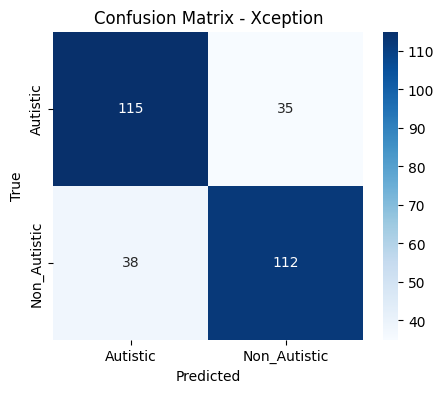

10/10 ━━━━━━━━━━━━━━━━━━━━ 187s 19s/step

VGG16 Results
Accuracy : 0.833
Sensitivity : 0.793
Specificity : 0.873

Classification Report:

              precision    recall  f1-score   support

    Autistic       0.81      0.87      0.84       150
Non_Autistic       0.86      0.79      0.83       150

    accuracy                           0.83       300
   macro avg       0.84      0.83      0.83       300
weighted avg       0.84      0.83      0.83       300



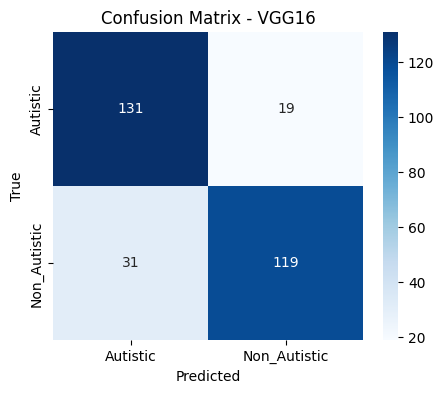

In [33]:

# Evaluation

def evaluate(model, name):
  preds = model.predict(test_data)
  y_pred = np.argmax(preds, axis=1)
  y_true = test_data.classes

  acc, sen, spe, cm = compute_metrics(y_true, y_pred)

  print(f"\n{name} Results")
  print("Accuracy :", round(acc, 3))
  print("Sensitivity :", round(sen, 3))
  print("Specificity :", round(spe, 3))
  print("\nClassification Report:\n")
  print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


  plt.figure(figsize=(5,4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
  xticklabels=CLASS_NAMES,
  yticklabels=CLASS_NAMES)
  plt.title(f"Confusion Matrix - {name}")
  plt.ylabel("True")
  plt.xlabel("Predicted")
  plt.show()

  return acc, sen, spe


acc_x, sen_x, spe_x = evaluate(xception_model, "Xception")
acc_v, sen_v, spe_v = evaluate(vgg16_model, "VGG16")

In [34]:

# Final Comparison

results = pd.DataFrame({
"Model": ["Xception", "VGG16"],
"Accuracy": [acc_x, acc_v],
"Sensitivity": [sen_x, sen_v],
"Specificity": [spe_x, spe_v]
})


results

,Model,Accuracy,Sensitivity,Specificity
0,Xception,0.756667,0.746667,0.766667
1,VGG16,0.833333,0.793333,0.873333


from matplotlib import pyplot as plt
results['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['Sensitivity'].plot(kind='hist', bins=20, title='Sensitivity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['Specificity'].plot(kind='hist', bins=20, title='Specificity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='Accuracy', y='Sensitivity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='Sensitivity', y='Specificity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Sensitivity']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Sensitivity'}, axis=1)
              .sort_values('Sensitivity', ascending=True))
  xs = counted['Sensitivity']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('Sensitivity', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Sensitivity')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Specificity']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Specificity'}, axis=1)
              .sort_values('Specificity', ascending=True))
  xs = counted['Specificity']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('Specificity', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Specificity')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['Sensitivity'].plot(kind='line', figsize=(8, 4), title='Sensitivity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['Specificity'].plot(kind='line', figsize=(8, 4), title='Specificity')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='Sensitivity', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='Specificity', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)